In [1]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_Ensemble_OHE_Kmer_Kgap_2"
outPath = "Results"
foldName = "folds.pickle"

# epochs = 100
# batch_size = 64
shuffle = True
seed = None

ohe_input_data_folder = "Data"
ohe_training_data_file = "Training-datasets-PredNTS.txt"
ohe_independent_data_file = "independent dataset-PredNTS.txt"

enc_data_folder = "PredNTS_MathFeature_ENC"
kmer_train_data_filename = 'Training-datasets-PredNTS_kmer.csv'
kmer_indpe_data_filename = 'independent-dataset-PredNTS_kmer.csv'

kgap_max = 4
kgap_train_data_filename = 'Training-datasets-PredNTS_kgap_{}.csv'
kgap_indpe_data_filename = 'independent-dataset-PredNTS_kgap_{}.csv'

callback_monitor = 'val_loss'

In [2]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression

import math

In [3]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [5]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(ohe_features, kmer_features, kgap_features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(ohe_features, labels):
        kfoldList.append({
            "X_OHE_train": ohe_features[train_index],
            "X_OHE_test": ohe_features[test_index],
            "X_Kmer_train": kmer_features[train_index],
            "X_Kmer_test": kmer_features[test_index],
            "X_Kgap_train": kgap_features[train_index],
            "X_Kgap_test": kgap_features[test_index],
            "y_train": labels[train_index],
            "y_test": labels[test_index]
        })
    return kfoldList

In [6]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

# Neural network models

In [7]:
ohe_epochs = 200
ohe_batch_size = 16
    
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def OHE_DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 256, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)
    
    x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    
    x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [8]:
kmer_epochs = 200
kmer_batch_size = 16

##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def Kmer_DLNN_Classifier(input_vec_shape,
                    dense_decode_units = 8, ## Dense layer parameters,
                    dense_layers = 2,
                    prob = 0.5, learn_rate = 0.0001, loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    input1 = tf.keras.layers.Input(shape=input_vec_shape)
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(input1)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(prob)(y)
    
    for i in range(1,dense_layers+1):
    
        y = tf.keras.layers.Dense(int(dense_decode_units/(2**i)), 
                                  kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                 )(y)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss)

    return model

In [9]:
kgap_epochs = 200
kgap_batch_size = 16

##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def Kgap_DLNN_Classifier(input_vec_shape,
                    dense_decode_units = 128, ## Dense layer parameters
                    prob = 0.5, learn_rate = 0.0001, loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    input1 = tf.keras.layers.Input(shape=input_vec_shape)
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(input1)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(int(dense_decode_units/2), 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(int(dense_decode_units/4), 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss)

    return model

In [10]:
OHE_DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 25)       5275        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 25)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 13, 25)       0           ['activation[0][0]']             
                                                                                              

In [11]:
Kmer_DLNN_Classifier((8420,)).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8420)]            0         
                                                                 
 dense_2 (Dense)             (None, 8)                 67368     
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                           

In [12]:
Kgap_DLNN_Classifier((2000,)).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_6 (Dense)             (None, 128)               256128    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0   

In [13]:
def logistic_classifier(cw = None):
    model = LogisticRegression(class_weight=cw)
    return model

# Training data preparation

In [14]:
##################################################################################
##### read SEQUENCE training file
##################################################################################
ohe_train_file_path = os.path.join(ohe_input_data_folder, ohe_training_data_file)
ohe_train_data = pd.read_csv(ohe_train_file_path, sep='\t', header=None)
ohe_train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
ohe_train_data.head()

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in ohe_train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
ohe_train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in ohe_train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
ohe_train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in ohe_train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

ohe_train_features = np.array(list(ohe_train_data['OHE_Sequence']))
labels = np.array(list(ohe_train_data['label']))
labels = labels.reshape((labels.shape[0], 1))

ohe_input_seq_shape = ohe_train_features[0].shape

############################################################################################################
############################################################################################################
##### Read KMER data
############################################################################################################
############################################################################################################

kmer_train_data_filepath = os.path.join(enc_data_folder, kmer_train_data_filename)
kmer_train_data = pd.read_csv(kmer_train_data_filepath, sep=',', header=0)
kmer_train_data = kmer_train_data.drop('label', axis=1)

kmer_train_data['label'] = pd.Series([int(val.split('_')[-2])
                                      for val in kmer_train_data['nameseq']])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

kmer_train_features = np.array(kmer_train_data.drop('label', axis=1).drop('nameseq', axis=1))
# train_labels = np.array(train_data['label'])
# train_labels = train_labels.reshape((train_labels.shape[0], 1))

kmer_input_vec_shape = kmer_train_features[0].shape

############################################################################################################
############################################################################################################
##### Read Kgap data
############################################################################################################
############################################################################################################

for i in range(kgap_max+1):
    
    kgap_current_train_data_filepath = os.path.join(enc_data_folder, kgap_train_data_filename.format(i))
    kgap_current_train_data = pd.read_csv(kgap_current_train_data_filepath, sep=',', header=0)
    kgap_current_train_data = kgap_current_train_data.drop('label', axis=1)
    
    if i == 0:
        kgap_train_data = kgap_current_train_data
    else:
        kgap_train_data = pd.merge(
            kgap_train_data,
            kgap_current_train_data,
            how="inner",
            on='nameseq'
        )

kgap_train_data['label'] = pd.Series([int(val.split('_')[-2])
                                      for val in kgap_train_data['nameseq']])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

kgap_train_features = np.array(kgap_train_data.drop('label', axis=1).drop('nameseq', axis=1))
# train_labels = np.array(train_data['label'])
# train_labels = train_labels.reshape((train_labels.shape[0], 1))

kgap_input_vec_shape = kgap_train_features[0].shape

############################################################################################################
############################################################################################################
##### Build folds
############################################################################################################
############################################################################################################

folds = build_kfold(ohe_train_features, kmer_train_features, kgap_train_features, labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

# Independent data preparation

In [15]:
##################################################################################
##### read independent data file
##################################################################################
ohe_indpe_file_path = os.path.join(ohe_input_data_folder, ohe_independent_data_file)
ohe_indpe_data = pd.read_csv(ohe_indpe_file_path, sep='\t', header=None)
ohe_indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
ohe_indpe_data.head()
    
##################################################################################
##### Create OHE of sequence
##################################################################################
ohe_indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in ohe_indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
ohe_indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in ohe_indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

ohe_indpe_features = np.array(list(ohe_indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(ohe_indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

############################################################################################################
############################################################################################################
##### Read Kmer data
############################################################################################################
############################################################################################################

kmer_indpe_data_filepath = os.path.join(enc_data_folder, kmer_indpe_data_filename)
kmer_indpe_data = pd.read_csv(kmer_indpe_data_filepath, sep=',', header=0)
kmer_indpe_data = kmer_indpe_data.drop('label', axis=1)

kmer_indpe_data['label'] = pd.Series([int(val.split('_')[-2])
                                 for val in kmer_indpe_data['nameseq']])

# kmer_indpe_data = kmer_indpe_data.drop('nameseq', axis=1)

##################################################################################
##### Extract features and labels, create folds
##################################################################################

kmer_indpe_features = np.array(kmer_indpe_data.drop('label', axis=1).drop('nameseq', axis=1))
# kmer_indpe_labels = np.array(kmer_indpe_data['label'])
# kmer_indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))


############################################################################################################
############################################################################################################
##### Read Kgap data
############################################################################################################
############################################################################################################

for i in range(kgap_max+1):

    kgap_current_indpe_data_filepath = os.path.join(enc_data_folder, kgap_indpe_data_filename.format(i))
    kgap_current_indpe_data = pd.read_csv(kgap_current_indpe_data_filepath, sep=',', header=0)
    kgap_current_indpe_data = kgap_current_indpe_data.drop('label', axis=1)
    
    if i == 0:
        kgap_indpe_data = kgap_current_indpe_data
    else:
        kgap_indpe_data = pd.merge(
            kgap_indpe_data,
            kgap_current_indpe_data,
            how="inner",
            on='nameseq'
        )

kgap_indpe_data['label'] = pd.Series([int(val.split('_')[-2])
                                      for val in kgap_indpe_data['nameseq']])

# kgap_indpe_data = kgap_indpe_data.drop('nameseq', axis=1)

##################################################################################
##### Extract features and labels, create folds
##################################################################################

kgap_indpe_features = np.array(kgap_indpe_data.drop('label', axis=1).drop('nameseq', axis=1))

# Training the ensemble

In [16]:
folds[0].keys()

dict_keys(['X_OHE_train', 'X_OHE_test', 'X_Kmer_train', 'X_Kmer_test', 'X_Kgap_train', 'X_Kgap_test', 'y_train', 'y_test'])

In [17]:
## Create and set directory to save all models
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

In [18]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_OHE_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    ##################################################################################
    ##### Train OHE network
    ##################################################################################
    
    print("Training OHE network.")
    
    ohe_model = OHE_DLNN_CORENup(input_seq_shape = ohe_input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    ohe_current_model_path = os.path.join(modelPath, "OHE_bestModel-fold{}.hdf5".format(i))
    ohe_modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(ohe_current_model_path,
                                           monitor = callback_monitor, verbose = 0, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    ohe_model.fit(x = fold["X_OHE_train"][index_arr], y = fold["y_train"][index_arr], 
                  batch_size = ohe_batch_size, epochs = ohe_epochs, verbose = 0, 
                  callbacks = ohe_modelCallbacks, validation_data = (fold["X_OHE_test"], fold["y_test"]))
    
    del ohe_model
    tf.keras.backend.clear_session()
    
#     ohe_model = tf.keras.models.load_model(ohe_current_model_path)
    
    ##################################################################################
    ##### Train Kmer network
    ##################################################################################
    
    print("Training Kmer network.")
    
    kmer_model = Kmer_DLNN_Classifier(input_vec_shape = kmer_input_vec_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    kmer_current_model_path = os.path.join(modelPath, "KMER_bestModel-fold{}.hdf5".format(i))
    kmer_modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(kmer_current_model_path,
                                           monitor = callback_monitor, verbose = 0, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    kmer_model.fit(x = fold["X_Kmer_train"][index_arr], y = fold["y_train"][index_arr], 
                   batch_size = kmer_batch_size, epochs = kmer_epochs, verbose = 0, 
                   callbacks = kmer_modelCallbacks, validation_data = (fold["X_Kmer_test"], fold["y_test"]))
    
    del kmer_model
    tf.keras.backend.clear_session()
    
#     kmer_model = tf.keras.models.load_model(kmer_current_model_path)
    
    ##################################################################################
    ##### Train Kgap network
    ##################################################################################
    
    print("Training Kgap network.")
    
    kgap_model = Kgap_DLNN_Classifier(input_vec_shape = kgap_input_vec_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    kgap_current_model_path = os.path.join(modelPath, "KGAP_bestModel-fold{}.hdf5".format(i))
    kgap_modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(kgap_current_model_path,
                                           monitor = callback_monitor, verbose = 0, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    kgap_model.fit(x = fold["X_Kgap_train"][index_arr], y = fold["y_train"][index_arr], 
                   batch_size = kgap_batch_size, epochs = kgap_epochs, verbose = 0, 
                   callbacks = kgap_modelCallbacks, validation_data = (fold["X_Kgap_test"], fold["y_test"]))
    
    del kgap_model
    tf.keras.backend.clear_session()
    
#     kgap_model = tf.keras.models.load_model(kgap_current_model_path)
    
    ##################################################################################
    ##### Generate scores for Train dataset
    ##################################################################################
    
    print("Generating the 3 scores.")
    
    ohe_model = tf.keras.models.load_model(ohe_current_model_path)
    ohe_train_y_pred = ohe_model.predict(fold["X_OHE_train"])
    ohe_test_y_pred = ohe_model.predict(fold["X_OHE_test"])
    
    del ohe_model
    tf.keras.backend.clear_session()
    
    kmer_model = tf.keras.models.load_model(kmer_current_model_path)
    kmer_train_y_pred = kmer_model.predict(fold["X_Kmer_train"])
    kmer_test_y_pred = kmer_model.predict(fold["X_Kmer_test"])
    
    del kmer_model
    tf.keras.backend.clear_session()
    
    kgap_model = tf.keras.models.load_model(kgap_current_model_path)
    kgap_train_y_pred = kgap_model.predict(fold["X_Kgap_train"])
    kgap_test_y_pred = kgap_model.predict(fold["X_Kgap_test"])
    
    del kgap_model
    tf.keras.backend.clear_session()
    
    ##################################################################################
    ##### Linear regression using the 3 scores
    ##################################################################################
    
    print("Training linear regression.")
    
    X_lr_train = np.concatenate((ohe_train_y_pred, kmer_train_y_pred, kgap_train_y_pred), axis=1)
    X_lr_test = np.concatenate((ohe_test_y_pred, kmer_test_y_pred, kgap_test_y_pred), axis=1)
    
    # lr_model = LogisticRegression(penalty='elasticnet')
    lr_model = logistic_classifier()
    lr_model.fit(X_lr_train, fold["y_train"].reshape((fold["y_train"].shape[0])))
    
    lr_current_model_path = os.path.join(modelPath, "LR_bestModel-fold{}.hdf5".format(i))
    lr_model_file_obj = open(lr_current_model_path, 'wb')
    pickle.dump(lr_model, lr_model_file_obj)
    lr_model_file_obj.close()
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################
    
    print("Generating train set metrics.")
    
    y_pred = lr_model.predict(X_lr_train)
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################
    
    print("Generating test set metrics.")

    y_pred = lr_model.predict(X_lr_test)
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Training OHE network.
Training Kmer network.
Training Kgap network.
Generating the 3 scores.
Training linear regression.
Generating train set metrics.
Generating test set metrics.

Train/Test model on Fold #1.
Training OHE network.
Training Kmer network.
Training Kgap network.
Generating the 3 scores.
Training linear regression.
Generating train set metrics.
Generating test set metrics.

Train/Test model on Fold #2.
Training OHE network.
Training Kmer network.
Training Kgap network.
Generating the 3 scores.
Training linear regression.
Generating train set metrics.
Generating test set metrics.

Train/Test model on Fold #3.
Training OHE network.
Training Kmer network.
Training Kgap network.
Generating the 3 scores.
Training linear regression.
Generating train set metrics.
Generating test set metrics.

Train/Test model on Fold #4.
Training OHE network.
Training Kmer network.
Training Kgap network.
Generating the 3 scores.
Training linear regression.
Generatin

## k-fold Training evaluation

In [19]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.816957,0.821317,0.816979,0.811093,0.822865,0.634636
Train,0.993283,0.993904,0.993283,0.992653,0.993913,0.986567


In [20]:
# val accuracy
# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Test	0.823258	0.836093	0.823267	0.805214	0.841321	0.647338
# Train	0.994438	0.995581	0.994437	0.993283	0.995592	0.988879

In [21]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.815514,0.826840,"[0.0, 0.799163179916318, 1.0]","[0.0, 0.16806722689075632, 1.0]","[2, 1, 0]",0.815548,0.799163,0.831933,0.631407
3,1,Test,0.825996,0.803922,"[0.0, 0.8613445378151261, 1.0]","[0.0, 0.20920502092050208, 1.0]","[2, 1, 0]",0.826070,0.861345,0.790795,0.653704
5,2,Test,0.806723,0.809322,"[0.0, 0.8025210084033614, 1.0]","[0.0, 0.18907563025210083, 1.0]","[2, 1, 0]",0.806723,0.802521,0.810924,0.613467
7,3,Test,0.810924,0.818966,"[0.0, 0.7983193277310925, 1.0]","[0.0, 0.17647058823529413, 1.0]","[2, 1, 0]",0.810924,0.798319,0.823529,0.622046
9,4,Test,0.825630,0.847534,"[0.0, 0.7941176470588235, 1.0]","[0.0, 0.14285714285714285, 1.0]","[2, 1, 0]",0.825630,0.794118,0.857143,0.652558


In [22]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Train,0.991076,0.991588,"[0.0, 0.990546218487395, 1.0]","[0.0, 0.008394543546694649, 1.0]","[2, 1, 0]",0.991076,0.990546,0.991605,0.982153
1,0,Test,0.815514,0.826840,"[0.0, 0.799163179916318, 1.0]","[0.0, 0.16806722689075632, 1.0]","[2, 1, 0]",0.815548,0.799163,0.831933,0.631407
2,1,Train,0.992126,0.993684,"[0.0, 0.9905561385099685, 1.0]","[0.0, 0.0063025210084033615, 1.0]","[2, 1, 0]",0.992127,0.990556,0.993697,0.984257
3,1,Test,0.825996,0.803922,"[0.0, 0.8613445378151261, 1.0]","[0.0, 0.20920502092050208, 1.0]","[2, 1, 0]",0.826070,0.861345,0.790795,0.653704
4,2,Train,0.993704,0.994742,"[0.0, 0.9926547743966422, 1.0]","[0.0, 0.005246589716684155, 1.0]","[2, 1, 0]",0.993704,0.992655,0.994753,0.987410
5,2,Test,0.806723,0.809322,"[0.0, 0.8025210084033614, 1.0]","[0.0, 0.18907563025210083, 1.0]","[2, 1, 0]",0.806723,0.802521,0.810924,0.613467
6,3,Train,0.994753,0.994753,"[0.0, 0.9947534102833159, 1.0]","[0.0, 0.005246589716684155, 1.0]","[2, 1, 0]",0.994753,0.994753,0.994753,0.989507
7,3,Test,0.810924,0.818966,"[0.0, 0.7983193277310925, 1.0]","[0.0, 0.17647058823529413, 1.0]","[2, 1, 0]",0.810924,0.798319,0.823529,0.622046
8,4,Train,0.994753,0.994753,"[0.0, 0.9947534102833159, 1.0]","[0.0, 0.005246589716684155, 1.0]","[2, 1, 0]",0.994753,0.994753,0.994753,0.989507
9,4,Test,0.825630,0.847534,"[0.0, 0.7941176470588235, 1.0]","[0.0, 0.14285714285714285, 1.0]","[2, 1, 0]",0.825630,0.794118,0.857143,0.652558


# Independent data

## Using k-fold Models

### Performance of each k-fold model

In [23]:
## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    ### OHE #####
    
    ohe_current_model_path = os.path.join(modelPath, "OHE_bestModel-fold{}.hdf5".format(i))
    ohe_model = tf.keras.models.load_model(ohe_current_model_path)
    
    ohe_y_pred = ohe_model.predict(ohe_indpe_features)
    
    del ohe_model
    tf.keras.backend.clear_session()
    
    ### Kmer #####
    
    kmer_current_model_path = os.path.join(modelPath, "KMER_bestModel-fold{}.hdf5".format(i))
    kmer_model = tf.keras.models.load_model(kmer_current_model_path)
    
    kmer_y_pred = kmer_model.predict(kmer_indpe_features)
    
    del kmer_model
    tf.keras.backend.clear_session()
    
    ### Kgap #####
    
    kgap_current_model_path = os.path.join(modelPath, "KGAP_bestModel-fold{}.hdf5".format(i))
    kgap_model = tf.keras.models.load_model(kgap_current_model_path)
    
    kgap_y_pred = kgap_model.predict(kgap_indpe_features)
    
    del kgap_model
    tf.keras.backend.clear_session()
    
    ### LR #####
    
    lr_indpe_features = np.concatenate((ohe_y_pred, kmer_y_pred, kgap_y_pred), axis=1)
    
    lr_current_model_path = os.path.join(modelPath, "LR_bestModel-fold{}.hdf5".format(i))
    lr_model_file_obj = open(lr_current_model_path, 'rb')
    lr_model = pickle.load(lr_model_file_obj)
    lr_model_file_obj.close()
    
    ############

    y_pred = lr_model.predict(lr_indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Independent")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.617796,0.245341,0.622114,0.628571,0.615656,0.183789


In [24]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.636735,0.256048,"[0.0, 0.625615763546798, 1.0]","[0.0, 0.3610567514677104, 1.0]","[2, 1, 0]",0.632280,0.625616,0.638943,0.200397
1,1,Independent,0.612245,0.240458,"[0.0, 0.6206896551724138, 1.0]","[0.0, 0.38943248532289626, 1.0]","[2, 1, 0]",0.615629,0.620690,0.610568,0.173798
2,2,Independent,0.616327,0.246679,"[0.0, 0.6403940886699507, 1.0]","[0.0, 0.388454011741683, 1.0]","[2, 1, 0]",0.625970,0.640394,0.611546,0.189207
3,3,Independent,0.604898,0.239332,"[0.0, 0.6354679802955665, 1.0]","[0.0, 0.40117416829745595, 1.0]","[2, 1, 0]",0.617147,0.635468,0.598826,0.175500
4,4,Independent,0.618776,0.244186,"[0.0, 0.6206896551724138, 1.0]","[0.0, 0.3816046966731898, 1.0]","[2, 1, 0]",0.619542,0.620690,0.618395,0.180044


### Mean score with k-fold models

In [25]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    ### OHE #####
    
    ohe_current_model_path = os.path.join(modelPath, "OHE_bestModel-fold{}.hdf5".format(i))
    ohe_model = tf.keras.models.load_model(ohe_current_model_path)
    
    ohe_y_pred = ohe_model.predict(ohe_indpe_features)
    
    del ohe_model
    tf.keras.backend.clear_session()
    
    ### Kmer #####
    
    kmer_current_model_path = os.path.join(modelPath, "KMER_bestModel-fold{}.hdf5".format(i))
    kmer_model = tf.keras.models.load_model(kmer_current_model_path)
    
    kmer_y_pred = kmer_model.predict(kmer_indpe_features)
    
    del kmer_model
    tf.keras.backend.clear_session()
    
    ### Kgap #####
    
    kgap_current_model_path = os.path.join(modelPath, "KGAP_bestModel-fold{}.hdf5".format(i))
    kgap_model = tf.keras.models.load_model(kgap_current_model_path)
    
    kgap_y_pred = kgap_model.predict(kgap_indpe_features)
    
    del kgap_model
    tf.keras.backend.clear_session()
    
    ### LR #####
    
    lr_indpe_features = np.concatenate((ohe_y_pred, kmer_y_pred, kgap_y_pred), axis=1)
    
    lr_current_model_path = os.path.join(modelPath, "LR_bestModel-fold{}.hdf5".format(i))
    lr_model_file_obj = open(lr_current_model_path, 'rb')
    lr_model = pickle.load(lr_model_file_obj)
    lr_model_file_obj.close()
    
    ############

    y_pred = lr_model.predict(lr_indpe_features)
    
    total_pred += y_pred[:, np.newaxis]
    all_preds.append(y_pred[:, np.newaxis])
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.631837,0.252988,0.655763,0.625616,0.633072,0.195582


### Voting score with k-fold models

In [26]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    ### OHE #####
    
    ohe_current_model_path = os.path.join(modelPath, "OHE_bestModel-fold{}.hdf5".format(i))
    ohe_model = tf.keras.models.load_model(ohe_current_model_path)
    
    ohe_y_pred = ohe_model.predict(ohe_indpe_features)
    
    del ohe_model
    tf.keras.backend.clear_session()
    
    ### Kmer #####
    
    kmer_current_model_path = os.path.join(modelPath, "KMER_bestModel-fold{}.hdf5".format(i))
    kmer_model = tf.keras.models.load_model(kmer_current_model_path)
    
    kmer_y_pred = kmer_model.predict(kmer_indpe_features)
    
    del kmer_model
    tf.keras.backend.clear_session()
    
    ### Kgap #####
    
    kgap_current_model_path = os.path.join(modelPath, "KGAP_bestModel-fold{}.hdf5".format(i))
    kgap_model = tf.keras.models.load_model(kgap_current_model_path)
    
    kgap_y_pred = kgap_model.predict(kgap_indpe_features)
    
    del kgap_model
    tf.keras.backend.clear_session()
    
    ### LR #####
    
    lr_indpe_features = np.concatenate((ohe_y_pred, kmer_y_pred, kgap_y_pred), axis=1)
    
    lr_current_model_path = os.path.join(modelPath, "LR_bestModel-fold{}.hdf5".format(i))
    lr_model_file_obj = open(lr_current_model_path, 'rb')
    lr_model = pickle.load(lr_model_file_obj)
    lr_model_file_obj.close()
    
    ############

    y_pred = lr_model.predict(lr_indpe_features)
    
    vote_pred = pred2label(y_pred[:, np.newaxis])
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.631837,0.252988,0.655763,0.625616,0.633072,0.195582


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [27]:
pos_indexes = np.where(indpe_labels==1)[0]
neg_indexes = np.random.permutation(np.where(indpe_labels==0)[0])[0:pos_indexes.shape[0]]
indpe_val_indexes = np.concatenate((pos_indexes, neg_indexes))

In [28]:
# adding random shuffling of the dataset for training purpose
index_arr = np.arange(ohe_train_features.shape[0])
index_arr = np.random.permutation(index_arr)

##################################################################################
##### Train OHE network
##################################################################################

print("Training OHE network.")

ohe_model = OHE_DLNN_CORENup(input_seq_shape = ohe_input_seq_shape)

## Define the model callbacks for early stopping and saving the model. Then train model
ohe_full_model_path = os.path.join(modelPath, "OHE_fullModel.hdf5".format(i))
ohe_modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(ohe_full_model_path,
                                       monitor = callback_monitor, verbose = 0, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

ohe_model.fit(x = ohe_train_features[index_arr], y = labels[index_arr], 
              batch_size = ohe_batch_size, epochs = ohe_epochs, verbose = 0, 
              callbacks = ohe_modelCallbacks, 
              validation_data = (ohe_indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))

del ohe_model
tf.keras.backend.clear_session()

##################################################################################
##### Train Kmer network
##################################################################################

print("Training Kmer network.")

kmer_model = Kmer_DLNN_Classifier(input_vec_shape = kmer_input_vec_shape)

## Define the model callbacks for early stopping and saving the model. Then train model
kmer_full_model_path = os.path.join(modelPath, "KMER_fullModel.hdf5".format(i))
kmer_modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(kmer_full_model_path,
                                       monitor = callback_monitor, verbose = 0, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

kmer_model.fit(x = kmer_train_features[index_arr], y = labels[index_arr], 
               batch_size = kmer_batch_size, epochs = kmer_epochs, verbose = 0, 
               callbacks = kmer_modelCallbacks, 
               validation_data = (kmer_indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))

del kmer_model
tf.keras.backend.clear_session()

##################################################################################
##### Train Kgap network
##################################################################################

print("Training Kgap network.")

kgap_model = Kgap_DLNN_Classifier(input_vec_shape = kgap_input_vec_shape)

## Define the model callbacks for early stopping and saving the model. Then train model
kgap_full_model_path = os.path.join(modelPath, "KGAP_fullModel.hdf5".format(i))
kgap_modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(kgap_full_model_path,
                                       monitor = callback_monitor, verbose = 0, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

kgap_model.fit(x = kgap_train_features[index_arr], y = labels[index_arr], 
               batch_size = kgap_batch_size, epochs = kgap_epochs, verbose = 0, 
               callbacks = kgap_modelCallbacks, 
               validation_data = (kgap_indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))

del kgap_model
tf.keras.backend.clear_session()

# kgap_model = tf.keras.models.load_model(kgap_current_model_path)

Training OHE network.
Training Kmer network.
Training Kgap network.


In [38]:
##################################################################################
##### Generate scores for Train dataset
##################################################################################

print("Generating the 3 scores.")

ohe_model = tf.keras.models.load_model(ohe_full_model_path)
ohe_train_y_pred = ohe_model.predict(ohe_train_features)
ohe_indpe_y_pred = ohe_model.predict(ohe_indpe_features)

del ohe_model
tf.keras.backend.clear_session()

kmer_model = tf.keras.models.load_model(kmer_full_model_path)
kmer_train_y_pred = kmer_model.predict(kmer_train_features)
kmer_indpe_y_pred = kmer_model.predict(kmer_indpe_features)

del kmer_model
tf.keras.backend.clear_session()

kgap_model = tf.keras.models.load_model(kgap_full_model_path)
kgap_train_y_pred = kgap_model.predict(kgap_train_features)
kgap_indpe_y_pred = kgap_model.predict(kgap_indpe_features)

del kgap_model
tf.keras.backend.clear_session()

##################################################################################
##### Linear regression using the 3 scores
##################################################################################

print("Training linear regression.")

X_lr_train = np.concatenate((ohe_train_y_pred, kmer_train_y_pred, kgap_train_y_pred), axis=1)
X_lr_indpe = np.concatenate((ohe_indpe_y_pred, kmer_indpe_y_pred, kgap_indpe_y_pred), axis=1)

lr_model = logistic_classifier(cw={0:1, 1:0.1})
lr_model.fit(X_lr_train, labels.reshape((labels.shape[0])))

lr_full_model_path = os.path.join(modelPath, "LR_fullModel.hdf5".format(i))
lr_model_file_obj = open(lr_full_model_path, 'wb')
pickle.dump(lr_model, lr_model_file_obj)
lr_model_file_obj.close()

Generating the 3 scores.
Training linear regression.


In [39]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = lr_model.predict(X_lr_indpe)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, label_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy',  
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Sensitivity,Specificity,MCC
Train_Test,,,,
Independent,0.766531,0.389163,0.841487,0.215735


In [31]:
# val accuracy
# 	Accuracy	Sensitivity	Specificity	MCC
# Train_Test				
# Independent	0.762449	0.399015	0.834638	0.215562

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
lr_model = DecisionTreeClassifier(criterion="gini",
                                  max_depth = 5,
                                  class_weight={0:1, 1:0.01}
                                 )
lr_model.fit(X_lr_train, labels.reshape((labels.shape[0])))

DecisionTreeClassifier(class_weight={0: 1, 1: 0.01}, max_depth=5)

In [34]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = lr_model.predict(X_lr_indpe)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, label_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy',  
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Sensitivity,Specificity,MCC
Train_Test,,,,
Independent,0.751837,0.364532,0.828767,0.178599


In [35]:
lr_model.feature_importances_

array([0.22456299, 0.7290962 , 0.0463408 ])

In [36]:
from matplotlib import pyplot as plt
from sklearn import tree

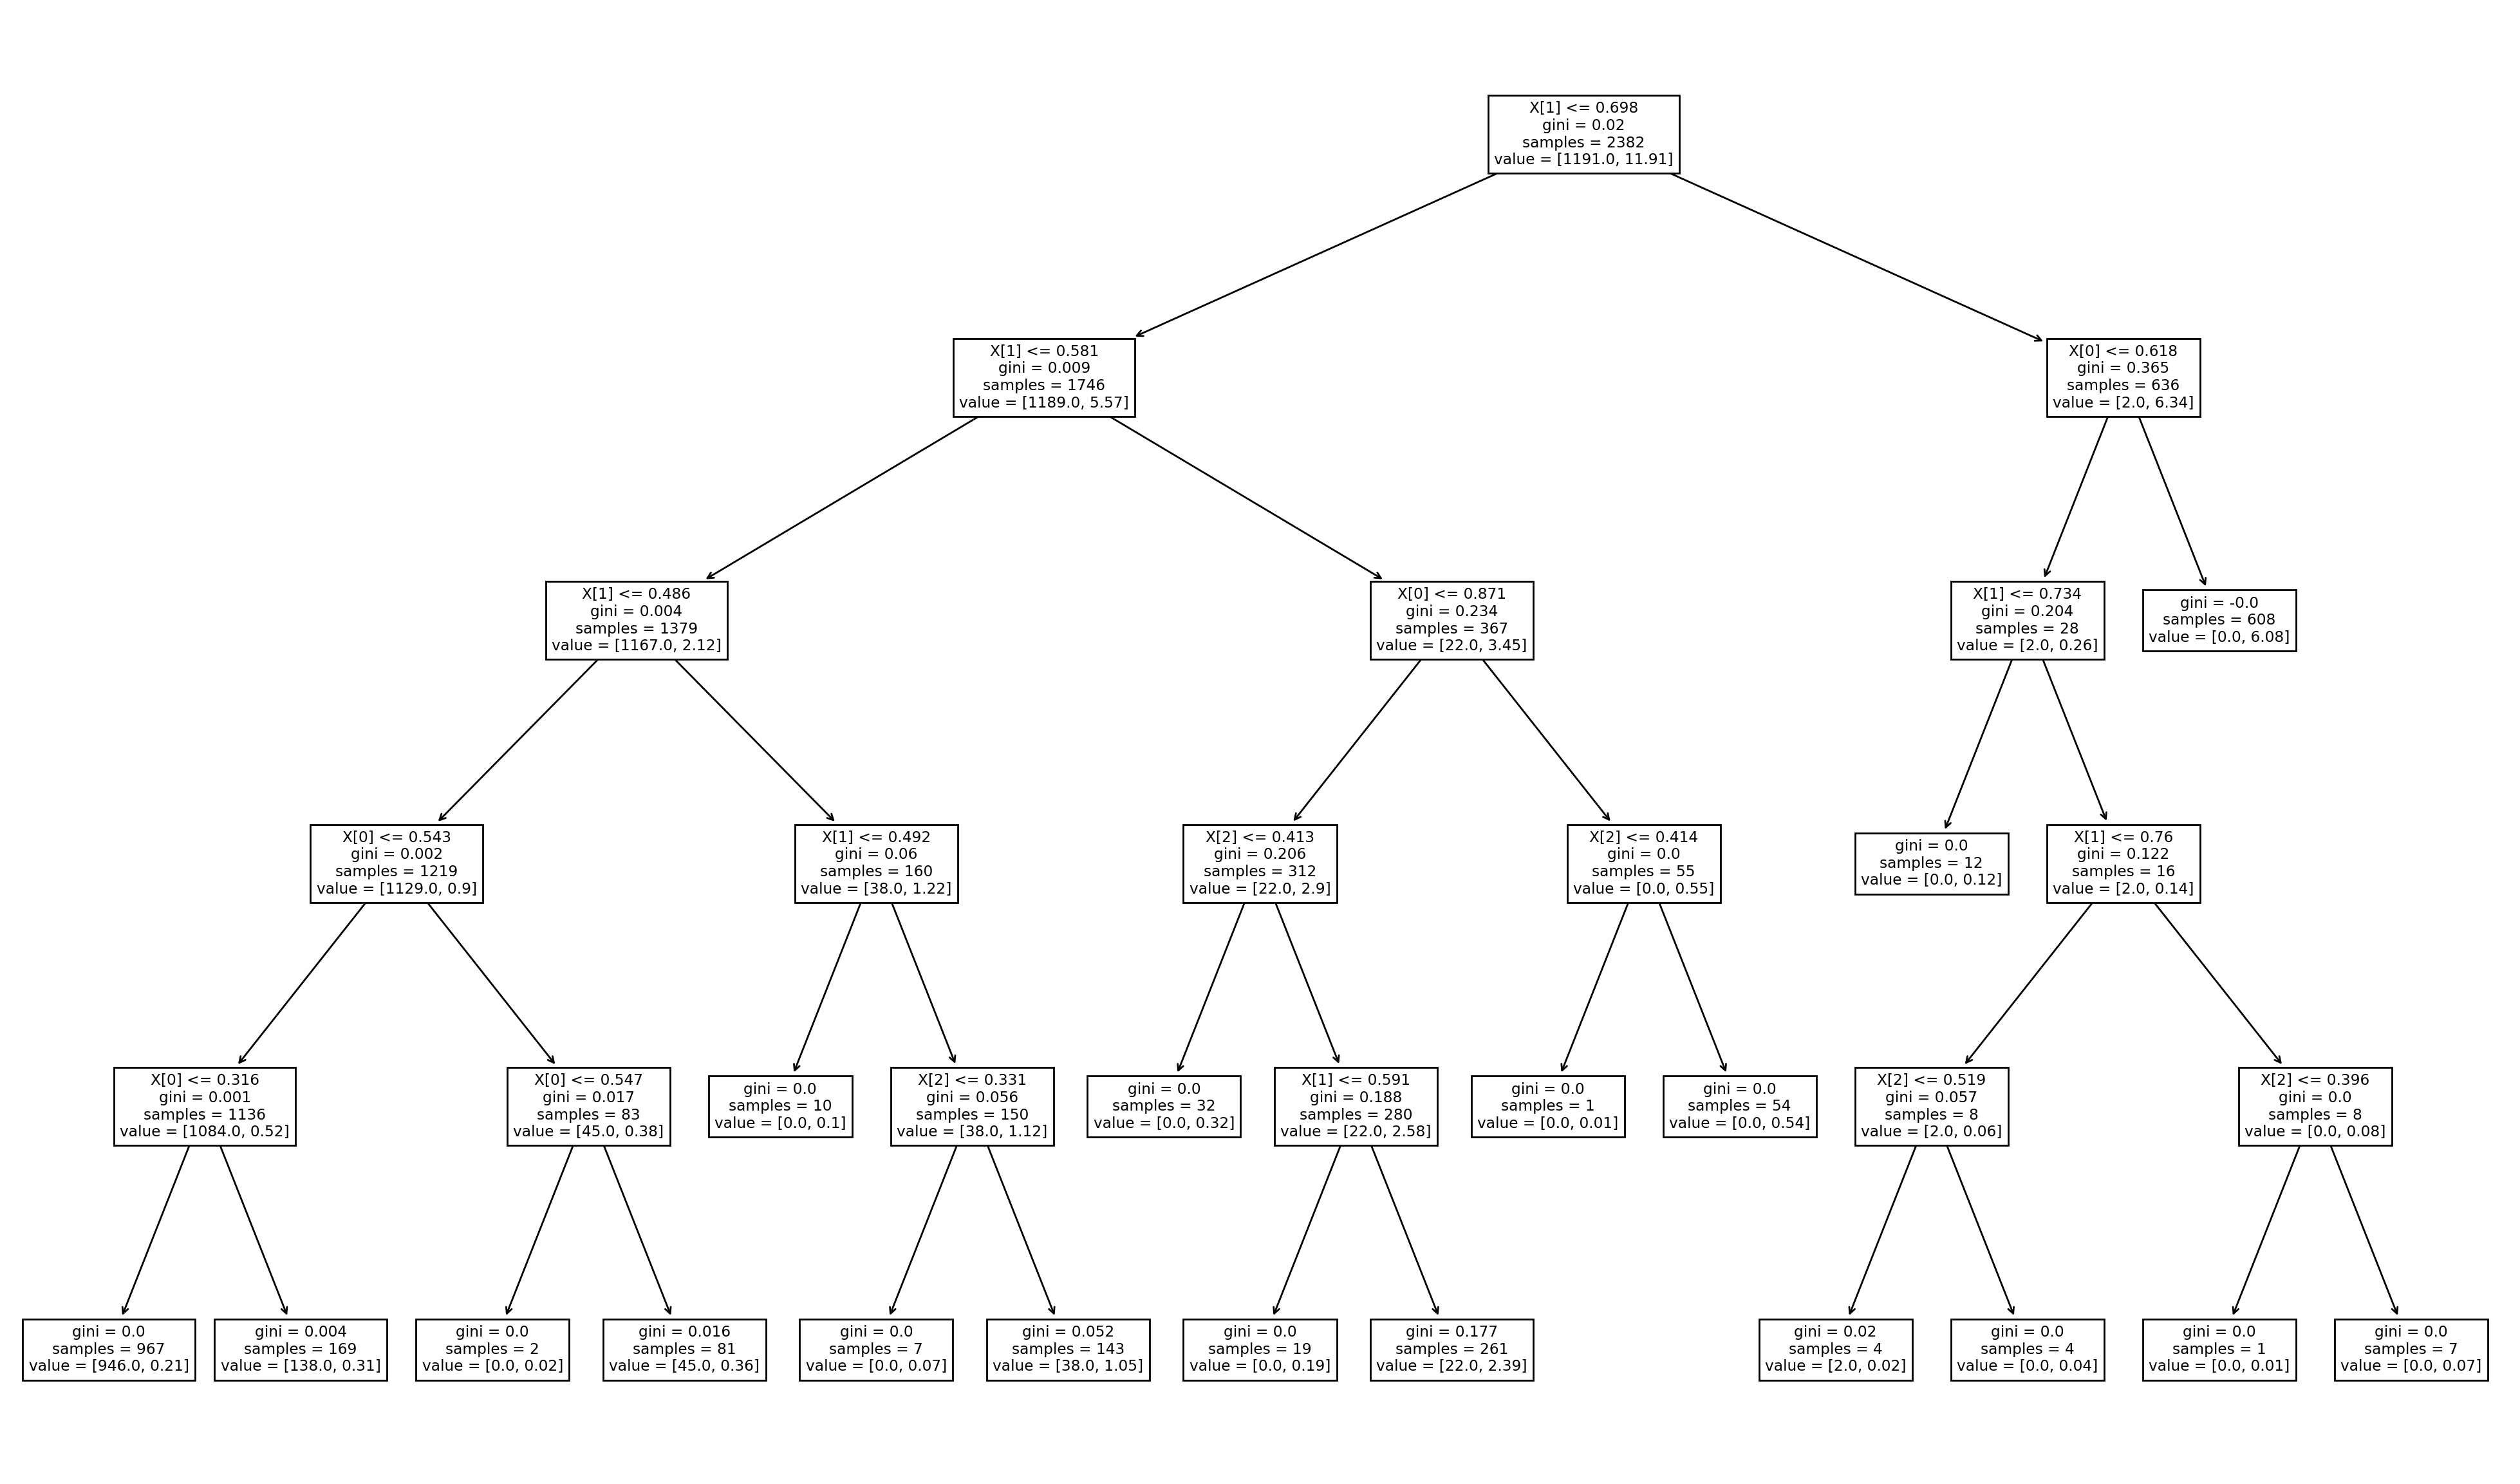

In [37]:
plt.figure(figsize=(25, 15), dpi = 200)
tree.plot_tree(lr_model)
plt.show()